In [18]:
import os
import sys
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../code")
warnings.filterwarnings("ignore")
from code.utils import read_tiff_file
from code.conv_lstm.utils import create_config, load_json_config, load_model
from code.conv_lstm.inference.predict import Predictor

from code.qubo.functions import combine_patches, extract_patches, pyqubo_solver, preprocess_image
from code.qubo.utils import plot_solution

# 1. Introduction
We can now formulate the problem as a Quadratic Unconstrained Binary Optimization (QUBO) problem, which can later be solved using the Quantum Adiabatic Algorithm (QAA) - see `QuRAWC_tutto` notebook. An instance of the QUBO problem is defined by a Q matrix which is diagonally symmetric, and the objective of the QUBO is to find the bitstring z that would minimize the following:

$$
\min_{z} z^T Q z
$$

where z is a given bitstring (vector) and Q is a square matrix which represents costs for locations on the map.

The Q matrix is a square matrix that has the same size as the number of pixels on the map, and it encodes associated costs for deploying a firefighter at location i in the map down the diagonal of the matrix, and the off-diagonal elements encode the costs for deploying a firefighter at two locations at the same time.

We first need to load the model that would give us predictions. More on this topic in the `conv_lstm` notebook.

In [20]:
args = {
    "fire_images_dir": "../data/sample_source_dataset/example_qubo",
    "model_path":'../code/conv_lstm/runs/run_13/1.pth',
    "config": '../code/conv_lstm/config.json',
    "time_steps":5,
    "threshold":9e-5,
}

json_config = load_json_config(args["config"])
config = create_config(json_config)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model = load_model(config)
model.load_state_dict(torch.load(args["model_path"], map_location=device))
model = model.to(device)

In [23]:
def plot_predictions(prediction, images_path):
    image_paths = sorted(file_path for file_path in os.listdir(images_path))

    images = []
    for path in image_paths:
        _, image, _ = read_tiff_file(os.path.join(images_path, path))
        fire = image[-1]
        fire = np.nan_to_num(fire, nan=0)
        fire[fire > 0] = 1
        images.append(fire)
    
    fig, axs = plt.subplots(1, 6, figsize=(21, 5))
    for j in range(5):
        af = images[j]
        axs[j].imshow(af * 255, cmap="gray")
        axs[j].set_title(f"Input {j + 1}")
    
    axs[5].imshow(prediction, cmap="gray")
    axs[5].set_title("Prediction")
    
    plt.show()
    plt.close(fig)

# 2. Conv-LSTM Predictions
Now we can make a prediction based on previos sightings of the wildfire and extract the features.

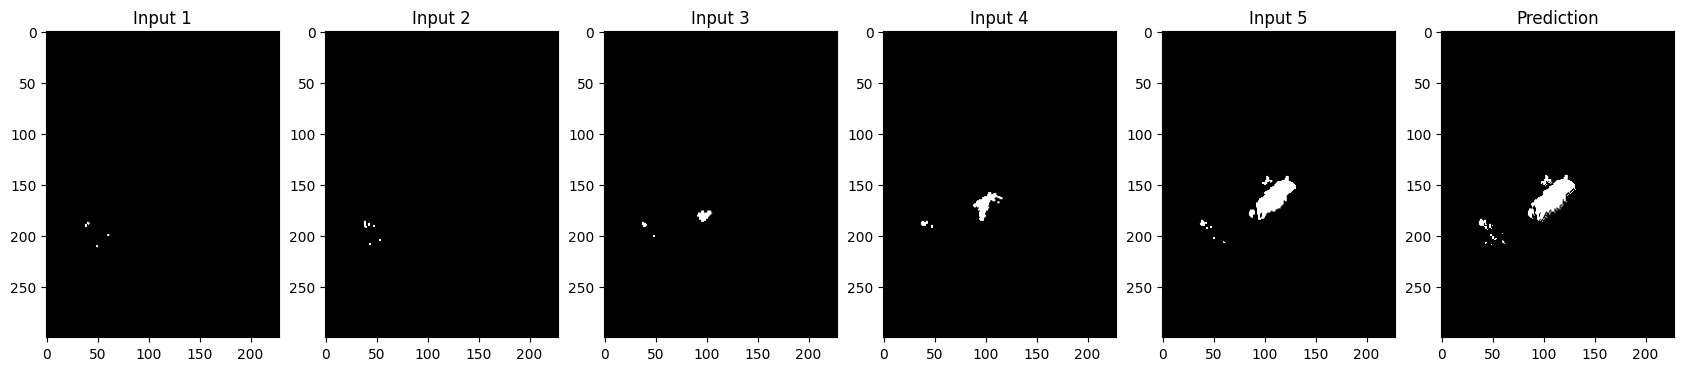

In [24]:
predictor = Predictor(args["fire_images_dir"], config=json_config, model_path=args["model_path"], threshold=args["threshold"])

prediction = np.squeeze(next(predictor()))

plot_predictions(prediction, args["fire_images_dir"])

In [25]:
image_path = max(file_path for file_path in os.listdir(args["fire_images_dir"]))
_, image, feature_labels = read_tiff_file(os.path.join(args["fire_images_dir"], image_path))

features_to_idx = {label: idx for idx, label in enumerate(feature_labels)}

# 3. QUBO
Finally, we can extract and process from the predicted image, create patches, and solve the QUBO 

pyqubo_solver create a binary quadratic model from a QUBO problem and returns the sample with the lowest-energy.

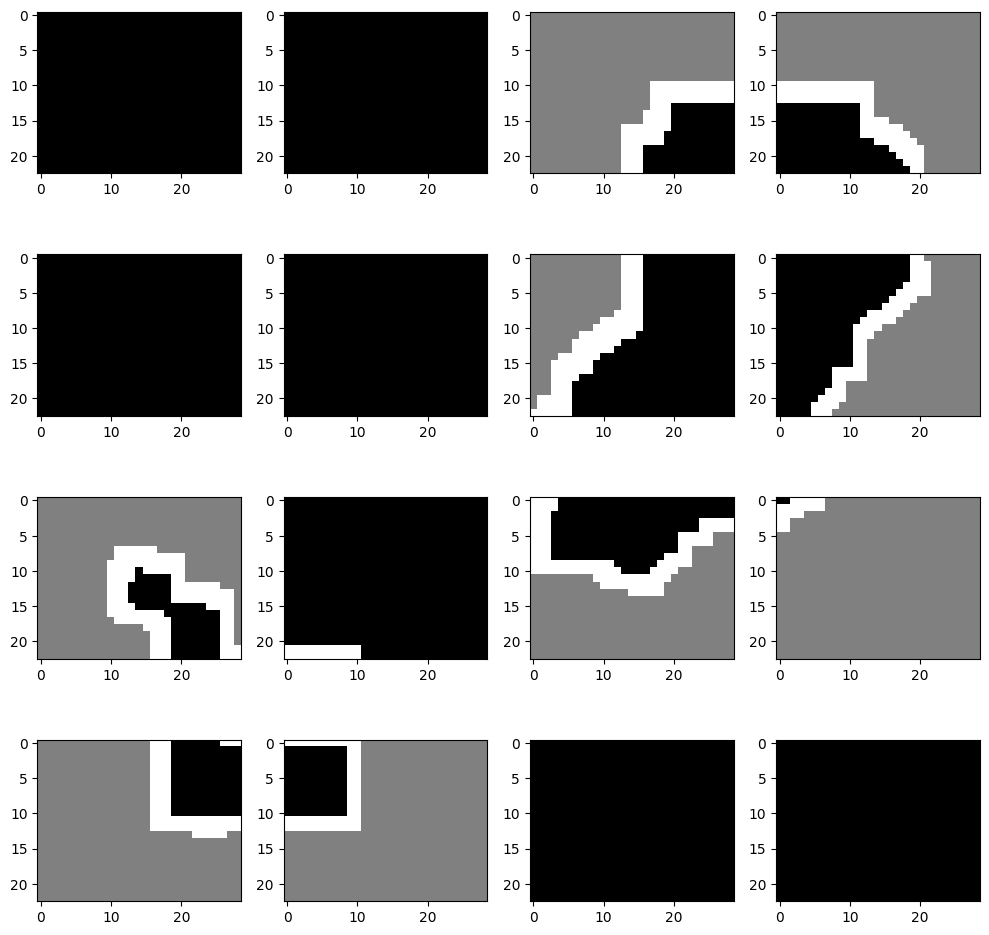

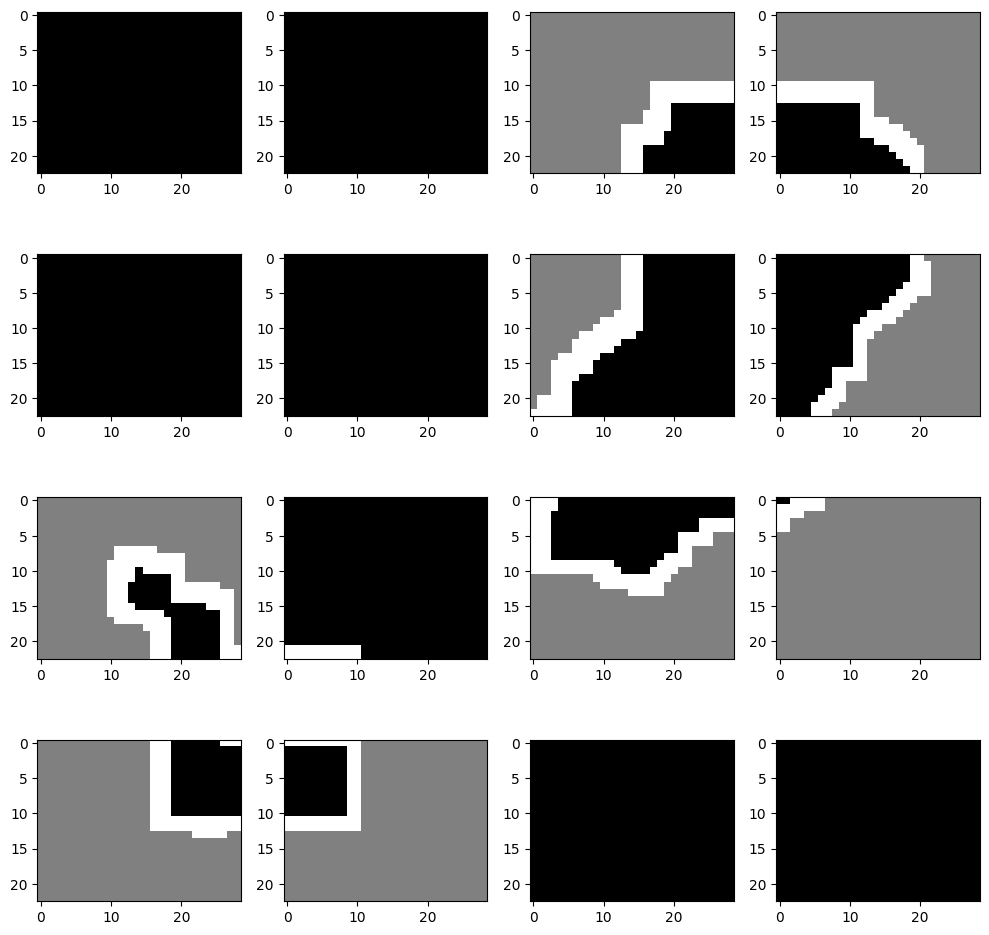

In [27]:
from code.qubo.functions import compute_qubo_matrix

num_patches = 16
patches_per_dim = int(num_patches**0.5)
exact_solver = num_patches <= 16

patches_horizon = []

processed_image = preprocess_image(image, features_to_idx, show_image=False)
patches = extract_patches(
    processed_image, features_to_idx, num_patches=num_patches, show_patches=True
)
patches_horizon.append(patches)

image[-1] = prediction

processed_image = preprocess_image(image, features_to_idx, show_image=False)
patches = extract_patches(
    processed_image, features_to_idx, num_patches=num_patches, show_patches=True
)
patches_horizon.append(patches)

patch_scores = combine_patches(patches_horizon, patches_per_dim)
qubo_matrix = compute_qubo_matrix(patch_scores, patches_per_dim)
solution = pyqubo_solver(
    qubo_matrix,
    num_atoms=num_patches,
    exact_solver=exact_solver,
)

# 4. Results - Regions of Interest
Below we can see the regions we would like to target (extinguish) marked in yellow

{'x0': 0, 'x1': 0, 'x10': 1, 'x11': 0, 'x12': 1, 'x13': 0, 'x14': 0, 'x15': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 0, 'x6': 1, 'x7': 1, 'x8': 0, 'x9': 0}


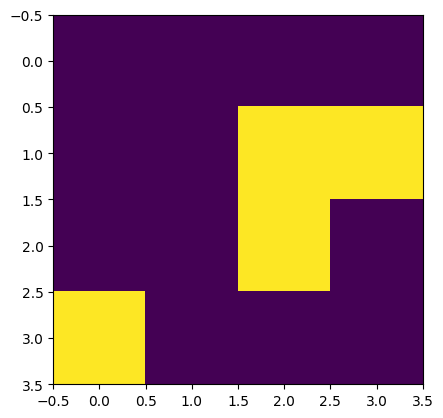

In [28]:
plot_solution(solution, patches_per_dim)